In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [3]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-31,335.500000,341.489990,321.040009,323.470001,323.470001,8535100
1,2017-08-01,323.000000,324.450012,316.130005,319.570007,319.570007,8303100
2,2017-08-02,318.940002,327.119995,311.220001,325.890015,325.890015,13091500
3,2017-08-03,345.329987,350.000000,343.149994,347.089996,347.089996,13535000
4,2017-08-04,347.000000,357.269989,343.299988,356.910004,356.910004,9268900


In [4]:
from collections import deque
import random


class Agent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.action_size = 3
        self.memory = deque(maxlen = 1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        tf.reset_default_graph()
        self.sess = tf.InteractiveSession()
        self.X = tf.placeholder(tf.float32, [None, self.state_size])
        self.Y = tf.placeholder(tf.float32, [None, self.action_size])
        feed = tf.layers.dense(self.X, 64, activation = tf.nn.relu)
        feed = tf.layers.dense(feed, 32, activation = tf.nn.relu)
        feed = tf.layers.dense(feed, 8, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed, self.action_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.GradientDescentOptimizer(1e-5).minimize(
            self.cost
        )
        self.sess.run(tf.global_variables_initializer())

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        return np.argmax(
            self.sess.run(self.logits, feed_dict = {self.X: state})[0]
        )

    def replay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])
        replay_size = len(mini_batch)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.action_size))
        states = np.array([a[0][0] for a in mini_batch])
        new_states = np.array([a[3][0] for a in mini_batch])
        Q = self.sess.run(self.logits, feed_dict = {self.X: states})
        Q_new = self.sess.run(self.logits, feed_dict = {self.X: new_states})
        for i in range(len(mini_batch)):
            state, action, reward, next_state, done = mini_batch[i]
            target = Q[i]
            target[action] = reward
            if not done:
                target[action] += self.gamma * np.amax(Q_new[i])
            X[i] = state
            Y[i] = target
        cost, _ = self.sess.run(
            [self.cost, self.optimizer], feed_dict = {self.X: X, self.Y: Y}
        )
        # print('cost: %f'%(cost))
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [5]:
close = df.Close.values.tolist()
window_size = 10
skip = 4
l = len(close) - 1
batch_size = 32
agent = Agent(window_size)
epoch = 50

In [6]:
for e in range(epoch):
    state = get_state(close, 0, window_size + 1)
    total_profit = 0
    agent.inventory = []
    for t in range(0, l, skip):
        action = agent.act(state)
        next_state = get_state(close, t + 1, window_size + 1)
        done = True
        reward = -10

        if action == 1:
            agent.inventory.append(close[t])
            # print("Buy on %d for %f"%(t,close[t]))

        elif action == 2 and len(agent.inventory) > 0:
            bought_price = agent.inventory.pop(0)
            reward = max(close[t] - bought_price, 0)
            done = False
            total_profit += close[t] - bought_price
            # print("Sell on %d for %f, Profit %f"%(t,close[t],close[t] - bought_price))

        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if len(agent.memory) > batch_size:
            agent.replay(batch_size)

    print('epoch %d, total profit %f' % (e + 1, total_profit))

epoch 1, total profit 0.310011
epoch 2, total profit -92.050109
epoch 3, total profit -119.140045
epoch 4, total profit -152.289978
epoch 5, total profit -143.129992
epoch 6, total profit -313.020050
epoch 7, total profit -407.860049
epoch 8, total profit -80.170031
epoch 9, total profit -288.190019
epoch 10, total profit -209.710054
epoch 11, total profit -185.569903
epoch 12, total profit -18.930088
epoch 13, total profit -139.529953
epoch 14, total profit -60.989900
epoch 15, total profit 97.430069
epoch 16, total profit 18.720047
epoch 17, total profit 46.569992
epoch 18, total profit -47.200027
epoch 19, total profit -106.610032
epoch 20, total profit -14.699969
epoch 21, total profit 145.960036
epoch 22, total profit 173.039992
epoch 23, total profit -59.910006
epoch 24, total profit -115.680024
epoch 25, total profit -128.130035
epoch 26, total profit -62.829988
epoch 27, total profit 12.689971
epoch 28, total profit -31.540010
epoch 29, total profit 10.779953
epoch 30, total pr

day 12: buy UNIT at price 362.910004, total balance 9637.089996
day 16: buy UNIT at price 341.350006, total balance 9295.739990
day 20, sell UNIT at price 345.660004, investment -4.753245 %, total balance 9641.399994,
day 24, sell UNIT at price 355.399994, investment 4.116006 %, total balance 9996.799988,
day 40: buy UNIT at price 345.250000, total balance 9651.549988
day 44, sell UNIT at price 341.529999, investment -1.077480 %, total balance 9993.079987,
day 52: buy UNIT at price 355.679993, total balance 9637.399994
day 56: buy UNIT at price 359.649994, total balance 9277.750000
day 60, sell UNIT at price 337.339996, investment -5.156320 %, total balance 9615.089996,
day 64, sell UNIT at price 320.079987, investment -11.002366 %, total balance 9935.169983,
day 68: buy UNIT at price 306.089996, total balance 9629.079987
day 72, sell UNIT at price 302.989990, investment -1.012776 %, total balance 9932.069977,
day 80: buy UNIT at price 317.809998, total balance 9614.259979
day 84, sell

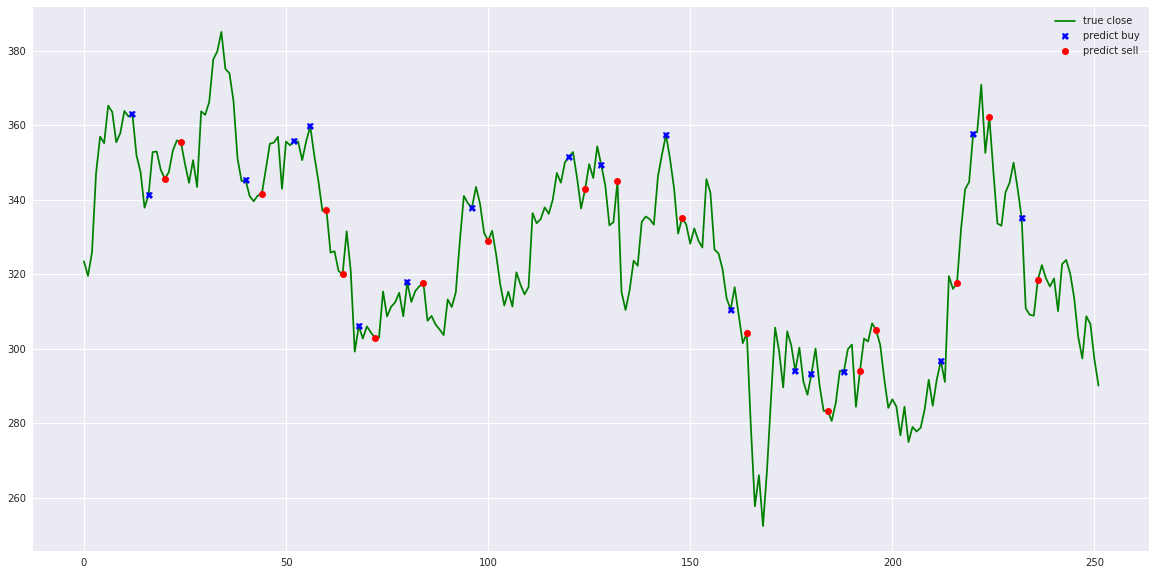

In [7]:
state = get_state(close, 0, window_size + 1)
initial_money = 10000
starting_money = initial_money
states_sell = []
states_buy = []
agent.inventory = []

for t in range(0, l, skip):
    action = agent.act(state)
    next_state = get_state(close, t + 1, window_size + 1)
    if action == 1 and initial_money >= close[t]:
        agent.inventory.append(close[t])
        initial_money -= close[t]
        states_buy.append(t)
        print(
            'day %d: buy UNIT at price %f, total balance %f'
            % (t, close[t], initial_money)
        )
    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        initial_money += close[t]
        states_sell.append(t)
        try:
            invest = ((close[t] - bought_price) / bought_price) * 100
        except:
            invest = 0
        print(
            'day %d, sell UNIT at price %f, investment %f %%, total balance %f,'
            % (t, close[t], invest, initial_money)
        )
    state = next_state

invest = ((initial_money - starting_money) / starting_money) * 100
print(
    '\ntotal gained %f, total investment %f %%'
    % (initial_money - starting_money, invest)
)
plt.figure(figsize = (20, 10))
plt.plot(close, label = 'true close', c = 'g')
plt.plot(close, 'X', label = 'predict buy', markevery = states_buy, c = 'b')
plt.plot(close, 'o', label = 'predict sell', markevery = states_sell, c = 'r')
plt.legend()
plt.show()